## Set-up 

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

In [158]:
import sklearn 
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [35]:
plt.rcParams.update({"figure.figsize": (20, 6)})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Preprocessing

In [161]:
events = pd.read_csv('int20h-ds-test-dataset.csv')

In [162]:
events.head(5)

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""White"",""Year"":""2019"",""Temporary"":""false"",""Start Date"":"""",""End Date"":"""",""Rental state"":""""}",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


In [163]:
users_info = events[['userid', 'user_state', 'event_platform', 'device_manufacture', 'device_model']]\
    .groupby('userid').agg(lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "None")

In [164]:
users_info = users_info.astype(dtype={
   col : "category" for col in users_info.columns
})

In [167]:
users = events[['userid', 'event_name']].groupby(['userid', 'event_name']).agg(
    count_col=pd.NamedAgg(column="event_name", aggfunc='count')
)
users = users.unstack(fill_value=0)
users.columns = [col[1] for col in users.columns]

In [179]:
users = users.join(users_info) 

In [180]:
users

,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Cancel,Subscription Premium Renew,Transaction Refund,Wallet Opened,user_state,event_platform,device_manufacture,device_model
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,MD,android,samsung,SM-A716U
000a59897372c5e3c147b15685fefc65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,ios,Apple,"iPhone11,6"
001244c572f1a681553bc045a378cacf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,FL,android,samsung,SM-G780G
0032cb66b99f6baef57ec2aa04a9277f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,ios,Apple,"iPhone14,3"
003f57fe2631ade57a86f6a2b96bb20c,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,ios,Apple,"iPhone13,4"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff9fd3437958123842f3ab75d22fc13f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,android,samsung,SM-N960U
ffa1aa12dd53aee84976cb6c525bb17b,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,TX,ios,Apple,"iPhone12,1"
ffbbc97af52745060a9dff4eb9917f75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,PA,ios,Apple,"iPhone12,1"


In [181]:
users.dtypes

Account History Transaction Details       int64
Account Setup Profile Skip                int64
Account Setup Skip                        int64
Add Payment Method Failed                 int64
Add Payment Method Success                int64
Add Vehicle Break                         int64
Add Vehicle Failed                        int64
Add Vehicle Success                       int64
Calculator Used                           int64
Calculator View                           int64
Chat Conversation Opened                  int64
Chat Conversation Started                 int64
Email Confirmation Success                int64
Order                                     int64
Reset Password Set                        int64
Sign Out                                  int64
Sign Up Error                             int64
Sign Up Success                           int64
Subscription Premium                      int64
Subscription Premium Cancel               int64
Subscription Premium Renew              

# Baseline xgboost

In [182]:
users_premium = users[users['Subscription Premium'] > 0]

In [183]:
X = users_premium.drop(columns=["Subscription Premium Cancel"])
y = users_premium["Subscription Premium Cancel"] > 0

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [185]:
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

In [186]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

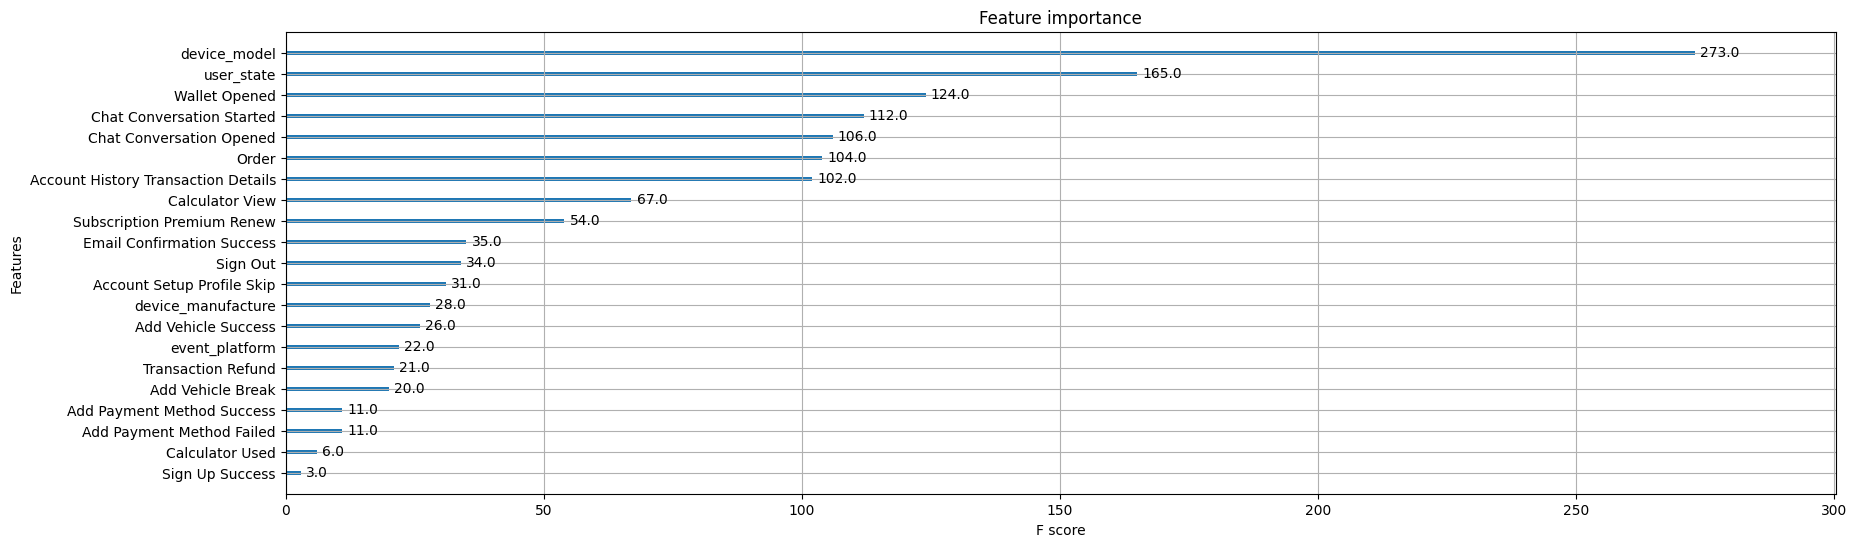

In [187]:
xgb.plot_importance(model)
plt.show()

In [188]:
y_test_pred = model.predict(X_test)

In [189]:
accuracy_score(y_test, y_test_pred)

0.8888888888888888

In [190]:
precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

(0.68, 1.0)